# TP1: Data Exploration

## Winter 2023 - BIN710 Data Mining (UdeS)

First assignement as part of the Data Mining class at UdeS.

Student name : Simon Lalonde

### Directory structure

├── TP1_data.csv    ---> Data

├── tp1.ipynb   ---> Jupyter Notebook

└── TP1.pdf    ---> Tasks to complete

### Metadata
csv file with :
- 59 objects
- 4 features
- 3 classes (as factors)

### Goal
Are all 4 features relevant for a classification task. The classifier will be distance based (KNN with K=5 or nearest centroid classifier)

### 1. Data Representation

In [147]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import seaborn as sns
from scipy.stats import shapiro 

Read, inspect and check for inconsistencies

In [148]:
datafile = Path("TP1_data.csv")
df = pd.read_csv(datafile, index_col=0)
df.head()

,attribut1,attribut2,attribut3,attribut4,classe
id1,38.0,33.0,10.0,19.0,0
id2,38.2,23.4,17.0,16.6,0
id3,33.0,24.0,19.0,23.0,0
id4,31.0,21.0,29.0,16.0,0
id5,37.0,27.0,24.0,12.0,0


In [149]:
# Check types, NaN or negative data
print(f"Data types : {np.unique(df.dtypes.to_list())}") # types

print(f"Number of rows with any NaN : {len(df.isna().any()[df.isna().any()])}") #NaN

# Check for neg data
print(f"Number of cols with negative values : {len((df < 0).any()[(df < 0).any()].index)}") # Negative vals

Data types : [dtype('int64') dtype('float64')]
Number of rows with any NaN : 0
Number of cols with negative values : 0


In [150]:
# Extracting features
cols = df.columns.to_list()
features = cols[:-1]
print(features)

['attribut1', 'attribut2', 'attribut3', 'attribut4']


In [151]:
# Separating features and classes
X = df[features]
y = df["classe"]

#### a) Evaluate correlations and possible transformations

Check correlations between features and then comparing between classes

In [152]:
# Check distributions
def get_distributions(data, features, plt_rows, plt_cols, bins='auto', binwidth=None, kde=True):
    # Square subplots
    fig, axes = plt.subplots(plt_rows, plt_cols, figsize=(10,10))
    axes = axes.ravel()

    for i, feat in enumerate(features):
        plot = sns.histplot(data[feat], kde=kde, ax=axes[i], bins=bins, binwidth=binwidth, color=sns.color_palette()[i])
        plot.set(title=f"Distribution for : {feat}")
        plot.set(xlabel="")

    fig.tight_layout()


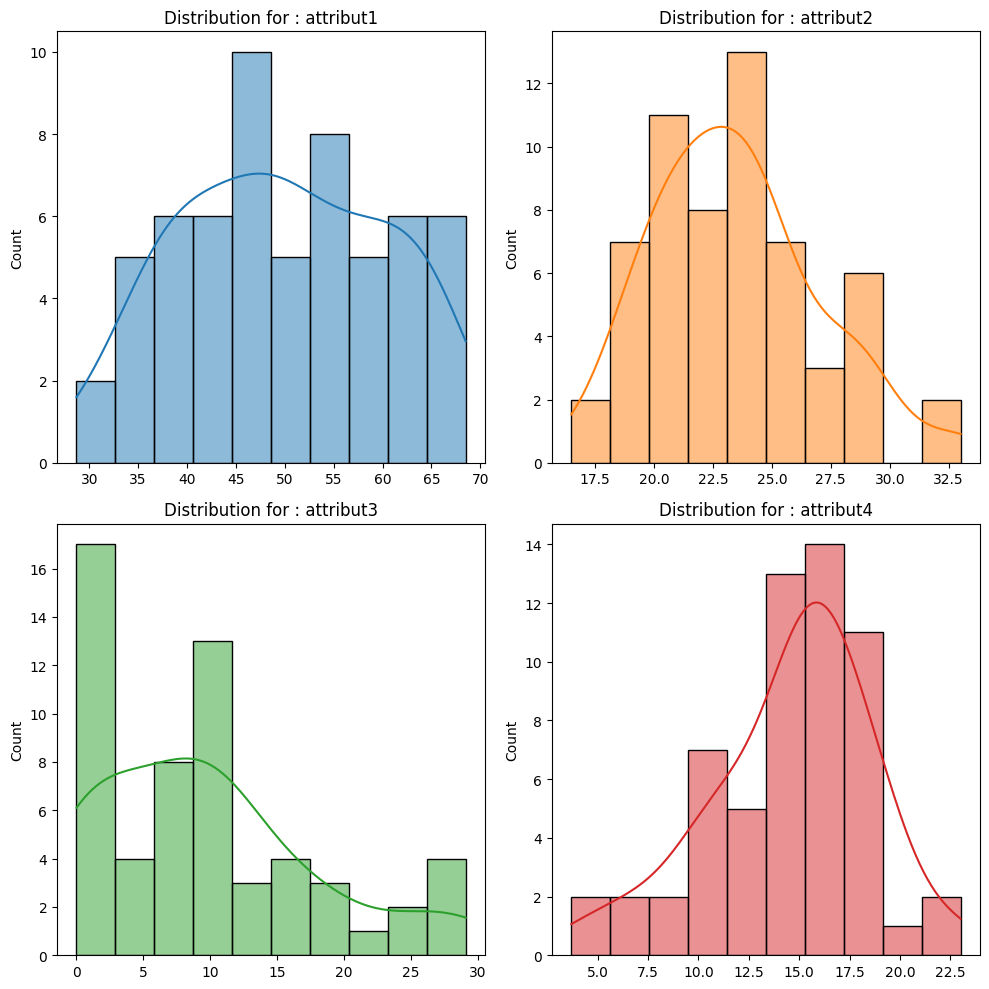

In [153]:
# Check distributions
get_distributions(X, features, 2, 2, bins=10, kde=True)


attribut1,2 and 4 seem normally distributed while 3 is more spread out (in kurtosis terms)

In [154]:
# Check for normality 
for feat in features:
    norm = shapiro(X[feat])
    if norm.pvalue < 0.05:
        print(f"{feat} is not normally distributed since pval={norm.pvalue} < 0.05")
    else:
        print(f"{feat} follows a normal distribution (null hypothesis)")

attribut1 follows a normal distribution (null hypothesis)
attribut2 follows a normal distribution (null hypothesis)
attribut3 is not normally distributed since pval=0.00028542501968331635 < 0.05
attribut4 follows a normal distribution (null hypothesis)


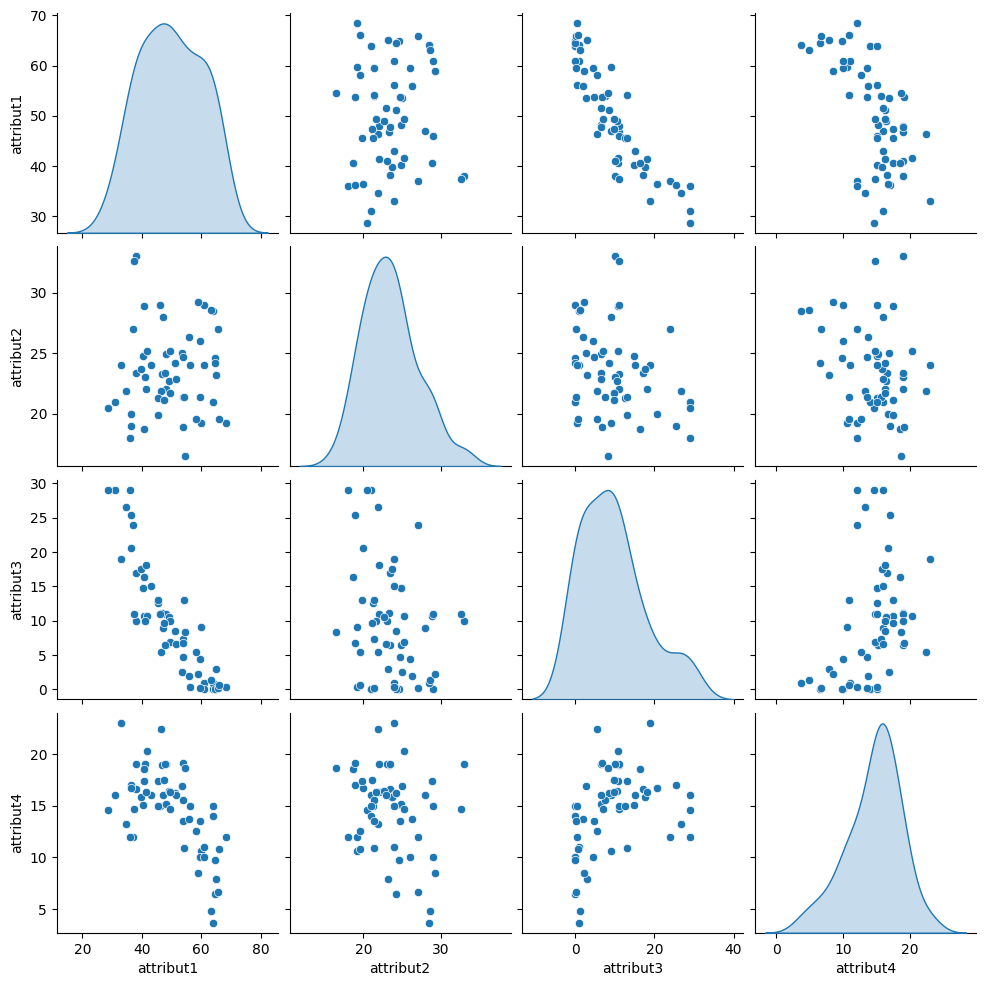

In [155]:
# Pairplot for features
g = sns.pairplot(X, diag_kind="kde")

g.tight_layout();

From the pairplot feature comparisons, we can say : 
- attribut1 and attribut3 seem inversely correlated
- attribut 1 and attribut 4 seem weakly inversely correlated 

In [156]:
# Pearson correlation
X.corr(method="pearson")

,attribut1,attribut2,attribut3,attribut4
attribut1,1.000000,0.017056,-0.890974,-0.622651
attribut2,0.017056,1.000000,-0.258163,-0.242347
attribut3,-0.890974,-0.258163,1.000000,0.372298
attribut4,-0.622651,-0.242347,0.372298,1.000000


In [157]:
# Check with other correlation coefficients for non-normal attribut3
X.corr(method="spearman")

,attribut1,attribut2,attribut3,attribut4
attribut1,1.000000,0.057114,-0.907870,-0.582645
attribut2,0.057114,1.000000,-0.229549,-0.212478
attribut3,-0.907870,-0.229549,1.000000,0.450973
attribut4,-0.582645,-0.212478,0.450973,1.000000
